In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix


from keras import backend as K

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import plot_tree
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

Using TensorFlow backend.


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000
INCLUDE_DIRECTION = False
LOAD_OLD_DATA_TRAIN = True
LOAD_OLD_DATA_TEST = False

# Load the data the old way


In [3]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [4]:
#  mapps the input records to a integer array for the input
def mapping_x( inp, include_direction = False , TrimAt= 15 ):
    if include_direction:
        return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1)  for x in inp ][:15])
    else:
        return np.array([ int(x["packet_length"])  for x in inp ][:15])

In [5]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [6]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S', include_direction=False):
    cleans = [] 
    cleans = (sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] ))
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    print( len(y_data), len(cleans) )
    
    ret_x  = [ mapping_x(x, include_direction=include_direction) for x in ret_x ] 
    ret_y_s = [ mapping_y_service(y) for y in ret_y ]
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    return ret_x, ret_y, ret_y_s

In [7]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = []
y_train = []
y_train_service = []

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    if LOAD_OLD_DATA_TRAIN:
        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
            y_data = json.load(f)

        with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
            x_data = json.load(f)

    #     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
    #         y_data = json.load(f)

    #     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
    #         x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )


        x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    else:
        
        for pick in sorted(glob.glob( '../files/new_data/train/hub_segments/*.json' )):
            fname  = os.path.basename(pick)
#             test_names.append( fname )
            with open( os.path.join( '../files/new_data/train/hub_segments/', fname) ) as f:
                y_data = json.load(f)

            with open( os.path.join('../files/new_data/train/pcap_segments/', fname) ) as f:
                x_data = json.load(f)

            if len( y_data ) != len(x_data) :
                print( pick )
                continue

            x_t,y_t, y_t_s= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    
            x_train.extend(x_t)
            y_train.extend(y_t)
            y_train_service.extend(y_t_s)
            

    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    files_path =  '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' if LOAD_OLD_DATA_TEST else '../files/new_data/usecases/pcap_segments_final/*.json'
    test_y_dir = '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/new_data/usecases/hub_segments_final/'
    test_x_dir = '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/' if LOAD_OLD_DATA_TEST else '../files/new_data/usecases/pcap_segments_final/'
    
    test_files = sorted(glob.glob(files_path))
    print( "found files : " , len(test_files) )
    
    
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        print(fname)
        with open( os.path.join(test_y_dir , fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join(test_x_dir, fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper, include_direction= INCLUDE_DIRECTION )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)


        x_test.append(t_x)
        y_test.append(t_y)
        y_test_service.append(t_z)
            
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True, include_direction=INCLUDE_DIRECTION )

        x.extend( t_x)
        y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
58958 57867
loading from test files
found files :  3
home_os_final.json
19090 19090
test_data_light.json
265 265
test_data_motion_2.json
10436 10436


(57867, 3)

# Evaluate Mittigation Techniques

## Packet Padding

In [8]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

In [9]:
# days =[7,4,2,2]
# t_sum =0
# d_sum = 0
# import math
# for ii in range(len(x_test)):

#     p = x_test[ii]
#     for i in p : 
#         t_sum += math.ceil(np.sum(i) / 2000)
#         d_sum+= np.sum( i )
# total_fixed  =  t_sum* 2000 / 15

# print ( total_fixed , d_sum, d_sum-t_sum*2000)

## Packet Insertion

In [10]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

# sets the classes 

In [11]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
# print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'ping'),
 (10, 'status'),
 (11, 'switch'),
 (12, 'temperature'),
 (13, 'threeAxis'),
 (14, 'unknown'),
 (15, 'water')]

## Filter the records by service/event types

In [12]:
def is_clean_event( inp, return_clean= True  ):
    return is_clean(inp, return_clean=return_clean, to_keep=[ 'no_logs', 'lock-unlocked', 'on/off-XXX', 'raw-XXX', 'read_attr_-_raw-XXX' ] )
#     if return_clean:
#         return  'no_logs' not in inp and 'lock-unlocked' not in inp and 'on/off-XXX' not in inp and 'raw-XXX' not in inp and 'read_attr_-_raw-XXX' not in inp
#     else:
#         return  'lock-locked' in inp or 'lock-unlocked'  in inp or 'on/off-XXX' in inp or  'raw-XXX' in inp  or 'read_attr_-_raw-XXX' in inp 
     
def is_clean_service( inp, return_clean= True  ):
    return is_clean(inp, to_keep=['no_logs','unknown', 'read_attr_-_raw'], return_clean=return_clean )
    
#     if return_clean:
#         return  'no_logs' not in inp and 'unknown' not in inp and 'read_attr_-_raw' not in inp #and 'ping' not in inp 
#     else:
#         return  'no_logs' in inp or  'unknown' in inp  or 'read_attr_-_raw' in inp #or 'ping' in inp 

def is_clean(inp, to_keep=[], return_clean=True):
    ret = False 
    
    for x  in to_keep:
        if x in inp:
            ret = True
            
    if not return_clean:
        ret = not ret
        
    return ret
    

choose services to keep : 

In [13]:
services_to_keep = service_classes#[ 'contact', 'lock', 'motion',"ping", 'switch','unknown'] 

find records which need change

In [14]:
train_indexes_to_change =  [ i for i in range(len(y_train)) if
              is_clean( y_train[i],to_keep=services_to_keep, return_clean=False) ] 

y_train = [ ['unknown'] if i in train_indexes_to_change else y_train[i] 
           for i in range(len(y_train)) ] 

for t_index in range(len(y_test)):
    test_indexes_to_change =  [ i for i in range(len(y_test[t_index])) if
                  is_clean( y_test[t_index][i],to_keep=services_to_keep, return_clean=False) ] 

    y_test[t_index] = [ ['unknown'] if i in test_indexes_to_change else y_test[t_index][i] 
               for i in range(len(y_test[t_index])) ] 

In [15]:
known_unknown_y_train = [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_train ]

known_unknown_y_test= [] 

for i in range(len(y_test)):
    
    known_unknown_y_test.append( [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_test[i] ])


remove classes that are ignored from the services list 

In [16]:
classes = services_to_keep

In [17]:
# toKeep = [ i for i in range(len(y_train)) if is_clean_event( y_train[i]) ] if Mapper=='SE' else [ i for i in range(len(y_train)) if is_clean_service( y_train[i]) ]
# x_train= [ x_train[i] for i in toKeep ]
# y_train= [ y_train[i] for i in toKeep ]


In [18]:
# for j in range(len(x_test)):
#     toChange= [ i for i in range(len(y_test[j])) if is_clean_service( y_test[j][i], False) ]
#     y_test[j] = [ (y_test[j][i] if i not in toChange else np.array( ['none'])) for i in range(len(y_test[j])) ]

In [19]:
# classes.remove('read_attr_-_raw-XXX')
# classes.remove('on/off-XXX')
# classes.remove('raw-XXX')
# classes.remove('lock-unlocked')
# classes.remove('lock-locked')


# classes.remove('read_attr_-_raw')
# classes.remove('on/off')
# classes.remove('raw')
# classes.remove('unknown')

# classes.remove('lock')
# # classes.remove('lock')


# classes.remove('switch-on')




## ===== end of unknown packet control=====

In [20]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,
                    classes=None, twoD= False, as_string=False ):
#  y data 
# """
# this functino is in charge of preprocessing the records , the sourc e json contains a lot of extra stuff, this function tailors
# the data and it fixes their lenghth
# """
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            if y in classes:
                temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        if twoD:
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size**2 - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size**2:
                    temp.append( 0 )

                x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


            x_data_temp = np.array( x_data_temp )
            x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
        else: 
            temp = [] 
            lst = list(x)
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size:
                    temp.append( 0 )
                
                x_data_temp.append(np.array( temp))
            
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / (np.amax( x_data_temp) + 0.000000000001)
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    if as_string:
        x_data_temp = [ ' '.join(list(map(str,x))) for x in x_data_temp ]
    
    return x_data_temp ,y_data_categorical , classes

In [21]:
x,y,_=pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=True, classes=classes)

In [22]:
np.amax(x), np.amin(x)

(0.9999999999999997, 0.0)

# Model Evaluation Methods

In [41]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
#     F= 2.0*( prec* recall )/ (prec+recall)
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    return acc, recall, prec, F

def acc_match( true, pred ):
    """
    returns exact mathc accuracy
    """
 
    return (len( [ x  for x  in  [np.sum(np.abs( true[i]- pred[i] )) for i in range(len(true))] if x  == 0]))*1.0 / len(true)


# def acc_none_zero ( true, pred ):
    

def acc_match_wierd( true, pred ):
    """
    returns exact mathc accuracy
    """
    level = 6 
    switch = 11
    threeAxis=13
    accel = 0 
    status=10
    contact=5
    
    counter  = 0 
    for i in range( len (true) ):
        if np.sum(np.abs( true[i]- pred[i] ))==0 :
            counter+=1
        else : 
            t_rec = np.array(list( pred[i]))
            
            if true[i][level]==1 and true[i][switch]==1 and t_rec[level]==1 :
                t_rec[switch]=1
            
            if true[i][threeAxis]==1 and true[i][accel]==1 and t_rec[threeAxis]==1:
                t_rec[accel] =1
            
            if true[i][status]==1 and true[i][contact]==1 and t_rec[status]==1:
                t_rec[contact]=1
#             print(t_rec , true[i])    
            if np.sum(np.abs( true[i]- t_rec ))==0 :
                counter+=1   
            
             
            
    
    return counter*1.0 / len(true)


def print_info(y_test, pred , classes , confidance=0.5, print_skf1=False):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%30s  %8s   %8s  %8s  %8s %8s %22s"  %( "Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP/TN/FP/FN"))
    print( "------------------------------------------------------------------------" )
    ret  = [] 
    ret_description = ["Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP","TN","FP","FN"]
    for index in range(len(classes)):
        tp = conf[index][1][1]
        tn = conf[index][0][0]
        fp = conf[index][0][1] 
        fn = conf[index][1][0]
        item = (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3],
              counts[index],
                  tp ,
                tn ,
                fp ,
                fn)
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %  item )
        ret.append(item)
        
    n_zeros_true = len([ x  for x  in  [np.sum(np.abs( y_test[i] )) for i in range(len(y_test))] if x  == 0]  )
    n_zeros_pred = len([ x  for x  in  [np.sum(np.abs( pred[i] )) for i in range(len(pred))] if x  == 0]  )
    
    accs = np.nan_to_num(accs)
    
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("AVERAGES",
              np.average( accs, axis=0)[0],
              np.average( accs, axis=0)[1],
              np.average( accs, axis=0)[2],
              np.average( accs, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("Weighted AVERAGES",
              np.average( accs, weights=counts, axis=0)[0],
              np.average( accs, weights=counts, axis=0)[1],
              np.average( accs, weights=counts, axis=0)[2],
              np.average( accs, weights=counts, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ("------------------------------------------------------------------------")
    unknonw_index = [classes.index('unknown')]
#     print(unknonw_index, len(accs))
    accs_new = np.delete(accs,unknonw_index,0)
    counts_new = [x for i,x in enumerate(counts) if i not in unknonw_index]
#     print(unknonw_index, len(counts), len(counts_new),len(accs), len(accs_new))
#     print(unknonw_index, len(accs))
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("known Weighted AVERAGES",
              np.average( accs_new, weights=counts_new, axis=0)[0],
              np.average( accs_new, weights=counts_new, axis=0)[1],
              np.average( accs_new, weights=counts_new, axis=0)[2],
              np.average( accs_new, weights=counts_new, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ("------------------------------------------------------------------------")
    if 'ping' in classes:
        unknonw_index = [classes.index('unknown'), classes.index('ping')]
    #     print(unknonw_index, len(accs))
        accs_new = np.delete(accs,unknonw_index,0)
        counts_new = [x for i,x in enumerate(counts) if i not in unknonw_index]
    #     print(unknonw_index, len(counts), len(counts_new),len(accs), len(accs_new))
    #     print(unknonw_index, len(accs))
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
                 ("known -ping Weighted AVERAGES",
                  np.average( accs_new, weights=counts_new, axis=0)[0],
                  np.average( accs_new, weights=counts_new, axis=0)[1],
                  np.average( accs_new, weights=counts_new, axis=0)[2],
                  np.average( accs_new, weights=counts_new, axis=0)[3],
                  len(y_test),
                      0 ,
                    0,
                    0 ,
                    0 ))

    print ("------------------------------------------------------------------------")
    unknonw_index = classes.index('unknown')
#     print(unknonw_index, len(accs))
    to_delete = [i for i,x in enumerate(counts) if x == 0 ]
    accs_new = np.delete(accs,to_delete,0)
    counts_new = [x for i,x in enumerate(counts) if i not in  to_delete]
#     print(unknonw_index, len(counts), len(counts_new),len(accs), len(accs_new))
#     print(unknonw_index, len(accs))
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("non zero count AVERAGES",
              np.average( accs_new, axis=0)[0],
              np.average( accs_new, axis=0)[1],
              np.average( accs_new, axis=0)[2],
              np.average( accs_new, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ("------------------------------------------------------------------------")
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, pred, average='macro')
    print("Macro F1 : %f" % f1)
    f1 = f1_score(y_test, pred, average='samples')
    print("sample F1 : %f" % f1)
    f1 = f1_score(y_test, pred, average='weighted')
    print("weighted F1 : %f" % f1)

    
    if 'ping' in classes and print_skf1:
        unknonw_index = classes.index('unknown')
        ping_index = classes.index('ping')
        print ("--------------------------removed ping and unknown----------------------------------------------")
        to_remove_indexes = [i for i,x in enumerate(pred) if x[ping_index]+x[unknonw_index] > 0.5]
        new_pred   =np.array( [x for i,x  in enumerate(pred) if i not in to_remove_indexes ])
        new_y_test = np.array([x for i,x  in enumerate(y_test) if i not in to_remove_indexes ])
        f1 = f1_score(new_y_test, new_pred, average='macro')
        print("Macro F1 : %f" % f1)
        f1 = f1_score(new_y_test, new_pred, average='samples')
        print("sample F1 : %f" % f1)
        f1 = f1_score(new_y_test, new_pred, average='weighted')
        print("weighted F1 : %f" % f1)

    
    
    print ( "Exact Match ACC : %.5f " % acc_match( y_test, pred )  )
#     print ( "Wierd Exact Match ACC : %.5f" % acc_wierd)
    print ( "Total Records : %d " % len(y_test)  )
    print ( "Total ZXeros in True : %d (%.3f)%%" % (n_zeros_true ,  n_zeros_true * 1.0/ len(y_test)  ))
    print ( "Total ZXeros in Test : %d (%.3f)%%" % (n_zeros_pred ,  n_zeros_pred * 1.0/ len(y_test)  ) )
    print ('=============================================================================')
    
    return ret, ret_description
    

In [24]:


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def make_readable_results ( inp , classes , conffidance=True):
    ret = [] 
    inp =inp.astype(int)
    for xx in range(len(inp)) :
        u = inp[xx]
        temp = []
        for j in range(len(u)) : 
            if u[j] >0:
                temp.append(classes[j])
        ret.append(temp)
    return ret


def makeReadable( model , data, gt, path , classes, x, confidance=0.5):
    #collect across multi models
    from keras.models import load_model
    x=[]
    for i in range(0,16):
        model=load_model('number'+str(i)+'.h5',custom_objects={'f1_perRow':f1_perRow,'f1_perClass':f1_perClass,'f1_loss_perRow':f1_loss_perRow,'f1_loss_perClass':f1_loss_perClass})
        x.append(model.predict(data))
    x=np.array(x)
    x=np.transpose(x)
    x=np.squeeze(x)
    print(x.shape)
        
        
    pred_temp  = x
    #pred_temp = model.predict(data)
    print_info(gt, x, classes , confidance=confidance)
#     print( len(classes ), len( pred_temp[0] ) )
#     xcc= make_readable_results(pred_temp , classes)
#     y_gt = make_readable_results( gt, classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] =  { 'seq': str(data[pick]),
#                                'pred': xcc[pick],
#                                 'true':y_gt[pick]
#                                }   

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)


# def makeReadable( model , data, gt, path , classes, confidance=0.7, x):
#     pred_temp = model.predict( data)
#     print_info(gt, pred_temp, classes , confidance=confidance)
#     xcc= make_readable_results( pred_temp , classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] = xcc[pick]  

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)

In [25]:
def add_unknowns_back(y_pred, original_y, indexes, classes):
    unknown = [1 if classes[i] == 'unknown' else
                        0  
                       for i in range(len(classes))]
    the_y = [unknown for i in range(len(original_y))]
    for i, v in enumerate(indexes):
#         print(v)
        the_y[v] = y_pred[i]
    return np.array(the_y)

get the data and preprocess train and test portions

In [26]:
dim_size= 20
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True) for i in range(len(x_test)) ] 

vectorize the X vars

In [98]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 5))
x_random_forest_train = vectorizer.fit_transform(x_random_forest_train)
for x in range(len(rf_tests)):
    rf_tests[x] = ( vectorizer.transform(rf_tests[x][0]),
                    rf_tests[x][1],
                    rf_tests[x][2]
                  )
    

# XGBoost 

In [28]:

xgb_known_unknown_separator_classifier = OneVsRestClassifier(XGBClassifier())

xgb_known_unknown_separator_classifier.fit(x_random_forest_train, np.array(known_unknown_y_train))

train_known_unknown_pred=xgb_known_unknown_separator_classifier.predict_proba(x_random_forest_train)


In [29]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=xgb_known_unknown_separator_classifier.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.787      0.723     0.940     0.817     12580  9097/ 5930/  580/ 3483
                         known     0.787      0.911     0.630     0.745      6510  5930/ 9097/ 3483/  580
------------------------------------------------------------------------
                      AVERAGES     0.787      0.817     0.785     0.781     19090     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.787      0.787     0.834     0.793     19090     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.787      0.911     0.630     0.745     19090     0/    0/    0/    0
----------

In [30]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [31]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_random_forest_train, np.array(y_random_forest_train))


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            

In [32]:
xg_boost_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    xg_boost_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.996      0.193     0.256     0.220        57    11/19001/   32/   46
                      activity     0.999      0.625     0.714     0.667        16    10/19070/    4/    6
                       battery     0.999      0.000     0.000     0.000         7     0/19075/    8/    7
                        button     1.000      0.750     0.692     0.720        12     9/19074/    4/    3
              colorTemperature     1.000      0.800     0.800     0.800         5     4/19084/    1/    1
                       contact     0.993      0.570     0.534     0.551       151    86/18864/   75/   65
                         level     0.986      0.800     0.057     0.106        20    16/18805/  265/    4
                          lock     1.000      0.941     0.889     0.914        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 : 0.408141
sample F1 : 0.169925
weighted F1 : 0.122055
Exact Match ACC : 0.75600 
Total Records : 19090 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 900 (0.047)%
==================HOME Case : test_data_light.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     1.000        nan       nan       nan         0     0/  265/    0/    0
                      activity     1.000        nan       nan       nan         0     0/  265/    0/    0
                       battery     1.000        nan       nan       nan         0     0/  265/    0/    0
                        button     1.000        nan       nan       nan         0     0/  265/    0/    0
              colorTemperature     0.977      0.871     0.931     0.900        31    27/  232/    2/    4
                       contact     1.000        nan       nan       nan         0     0/  265/    0/    0
                         level     0.849      0.723     0.779     0.750        83    60/  165/   17/   23
                          lock     1.000        nan       nan       nan         

In [33]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=xgb_known_unknown_separator_classifier.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.787      0.723     0.940     0.817     12580  9097/ 5930/  580/ 3483
                         known     0.787      0.911     0.630     0.745      6510  5930/ 9097/ 3483/  580
------------------------------------------------------------------------
                      AVERAGES     0.787      0.817     0.785     0.781     19090     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.787      0.787     0.834     0.793     19090     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.787      0.911     0.630     0.745     19090     0/    0/    0/    0
----------

separate known and unknowns 

In [34]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [35]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_random_forest_train, np.array(y_random_forest_train))

# train_known_unknown_pred=xgb_classifier.predict_proba(x_random_forest_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            

with putting back teh unknowns

In [36]:
xg_boost_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    xg_boost_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.996      0.193     0.256     0.220        57    11/19001/   32/   46
                      activity     0.999      0.625     0.714     0.667        16    10/19070/    4/    6
                       battery     0.999      0.000     0.000     0.000         7     0/19075/    8/    7
                        button     1.000      0.750     0.692     0.720        12     9/19074/    4/    3
              colorTemperature     1.000      0.800     0.800     0.800         5     4/19084/    1/    1
                       contact     0.993      0.570     0.534     0.551       151    86/18864/   75/   65
                         level     0.986      0.800     0.057     0.106        20    16/18805/  265/    4
                          lock     1.000      0.941     0.889     0.914        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


------------------------------------------------------------------------
                      AVERAGES     0.973      0.520     0.519     0.493     19090     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.842      0.753     0.898     0.815     19090     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.973      0.812     0.819     0.810     19090     0/    0/    0/    0
------------------------------------------------------------------------
 known -ping Weighted AVERAGES     0.941      0.477     0.380     0.411     19090     0/    0/    0/    0
------------------------------------------------------------------------
       non zero count AVERAGES     0.974      0.589     0.589     0.558     19090     0/    0/    0/    0
------------------------------------------------------------------------
Macro F1 : 0.492506
sample F1 : 

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Macro F1 : 0.408141
sample F1 : 0.169925
weighted F1 : 0.122055
Exact Match ACC : 0.75600 
Total Records : 19090 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 900 (0.047)%
==================HOME Case : test_data_light.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     1.000        nan       nan       nan         0     0/  265/    0/    0
                      activity     1.000        nan       nan       nan         0     0/  265/    0/    0
                       battery     1.000        nan       nan       nan         0     0/  265/    0/    0
                        button     1.000        nan       nan       nan         0     0/  265/    0/    0
              colorTemperature     0.977      0.871     0.931     0.900        31    27/  232/    2/    4
                       contact     1.000        nan       nan       nan         0     0/  265/    0/    0
                         level     0.849      0.723     0.779     0.750        83    60/  165/   17/   23
                          lock     1.000        nan       nan       nan         

with out putting back the unknowns : 

In [37]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.992      0.212     0.256     0.232        52    11/ 9329/   32/   41
                      activity     0.999      0.667     0.714     0.690        15    10/ 9394/    4/    5
                       battery     0.999      0.000     0.000     0.000         2     0/ 9403/    8/    2
                        button     0.999      0.750     0.692     0.720        12     9/ 9397/    4/    3
              colorTemperature     1.000      0.800     0.800     0.800         5     4/ 9407/    1/    1
                       contact     0.986      0.597     0.534     0.564       144    86/ 9194/   75/   58
                         level     0.971      0.800     0.057     0.106        20    16/ 9128/  265/    4
                          lock     0.999      0.970     0.889     0.928        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     1.000        nan       nan       nan         0     0/  182/    0/    0
                      activity     1.000        nan       nan       nan         0     0/  182/    0/    0
                       battery     1.000        nan       nan       nan         0     0/  182/    0/    0
                        button     1.000        nan       nan       nan         0     0/  182/    0/    0
              colorTemperature     0.967      0.871     0.931     0.900        31    27/  149/    2/    4
                       contact     1.000        nan       nan       nan         0     0/  182/    0/    0
                         level     0.780      0.723     0.779     0.750        83    60/   82/   17/   23
                          lock     1.000        nan       nan       nan         

# Random Forest 

## string encoding test

In [38]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=100, max_depth=400,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [39]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [40]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.783      0.716     0.940     0.813     12580  9010/ 5938/  572/ 3570
                         known     0.783      0.912     0.625     0.741      6510  5938/ 9010/ 3570/  572
------------------------------------------------------------------------
                      AVERAGES     0.783      0.814     0.782     0.777     19090     0/    0/    0/    0
------------------------------------------------------------------------
             Weighted AVERAGES     0.783      0.783     0.833     0.789     19090     0/    0/    0/    0
------------------------------------------------------------------------
       known Weighted AVERAGES     0.783      0.912     0.625     0.741     19090     0/    0/    0/    0
----------

In [41]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=400,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [43]:
rf_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    rf_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.996      0.000     0.000     0.000        57     0/19020/   13/   57
                      activity     0.999      0.062     1.000     0.118        16     1/19074/    0/   15
                       battery     0.999      0.000     0.000     0.000         7     0/19073/   10/    7
                        button     0.999      0.000     0.000     0.000        12     0/19077/    1/   12
              colorTemperature     1.000      1.000     0.833     0.909         5     5/19084/    1/    0
                       contact     0.991      0.391     0.431     0.410       151    59/18861/   78/   92
                         level     0.985      0.750     0.050     0.094        20    15/18787/  283/    5
                          lock     1.000      0.882     0.882     0.882        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Macro F1 : 0.351835
sample F1 : 0.750873
weighted F1 : 0.805876
--------------------------removed ping and unknown----------------------------------------------
Macro F1 : 0.257943
sample F1 : 0.152902
weighted F1 : 0.102496
Exact Match ACC : 0.74924 
Total Records : 19090 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 1210 (0.063)%
==================HOME Case : test_data_light.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     1.000        nan       nan       nan         0     0/  265/    0/    0
                      activity     1.000        nan       nan       nan         0     0/  265/    0/    0
                       battery     1.000        nan       nan       nan         0     0/  265/    0/    0
                        button     1.000        nan       nan       nan         0     0/  265/    0/    0
              colorTemperature     0.887      0.032     1.000     0.062        31     1/  234/    0/   30
                       contact     1.000        nan       nan       nan         0     0/  265/    0/    0
                         level     0.853      0.867     0.720     0.787        83    72/  154/   28/   11
                          lock     1.000        nan       nan       nan         

In [44]:
# for i in range(len(rf_test_known)) :
#     print( "==================HOME Case : %s =============" % test_names[ i] )
#     rf_pred= clf.predict( rf_test_known[i][0])
#     print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.993      0.000     0.000     0.000        52     0/ 9443/   13/   52
                      activity     0.998      0.062     1.000     0.118        16     1/ 9492/    0/   15
                       battery     0.999      0.000     0.000     0.000         3     0/ 9495/   10/    3
                        button     0.999      0.000     0.000     0.000        12     0/ 9495/    1/   12
              colorTemperature     1.000      1.000     0.833     0.909         5     5/ 9502/    1/    0
                       contact     0.983      0.413     0.431     0.421       143    59/ 9287/   78/   84
                         level     0.970      0.750     0.050     0.094        20    15/ 9205/  283/    5
                          lock     0.999      0.909     0.882     0.896        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.996      0.000     0.000     0.000        25     0/ 7434/    2/   25
                      activity     1.000        nan       nan       nan         0     0/ 7461/    0/    0
                       battery     1.000      0.000       nan     0.000         1     0/ 7460/    0/    1
                        button     1.000        nan     0.000     0.000         0     0/ 7459/    2/    0
              colorTemperature     1.000      0.667     1.000     0.800         3     2/ 7458/    0/    1
                       contact     0.985      0.009     0.167     0.017       110     1/ 7346/    5/  109
                         level     0.996      1.000     0.143     0.250         5     5/ 7426/   30/    0
                          lock     0.999        nan     0.000     0.000         

In [45]:
values, desc = print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.000       nan     0.000        10     0/ 3180/    0/   10
                      activity     1.000        nan       nan       nan         0     0/ 3190/    0/    0
                       battery     1.000        nan       nan       nan         0     0/ 3190/    0/    0
                        button     1.000        nan       nan       nan         0     0/ 3190/    0/    0
              colorTemperature     1.000      0.667     1.000     0.800         3     2/ 3187/    0/    1
                       contact     0.990      0.000       nan     0.000        33     0/ 3157/    0/   33
                         level     0.991      1.000     0.147     0.256         5     5/ 3156/   29/    0
                          lock     0.997        nan     0.000     0.000         

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [ ]:
def fix_nan(inp):
    if np.isnan(inp):
        return 0
    else:
        return inp
desc = xg_boost_results[0][1]
index = 0 
for index in range(len(test_names)):
    plt.figure(figsize=(14,4))
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in xg_boost_results[index][0]],
        label="XGBoost",
         color="red" ,
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in rf_results[index][0]],
        label="RF",
         color="blue" ,
             alpha=0.5
        )
    
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Precision",
         color="red" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in rf_results[index][0]],
        label="RF - Precision",
         color="blue" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Recall",
         color="red" ,
             marker="+",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in rf_results[index][0]],
        label="RF - Recall",
         color="blue" ,
             marker="+",
             alpha=0.5
        )

    # plt.plot( )
    plt.legend()
    plt.xticks(rotation=90, ha='right')
    plt.title(test_names[ index] )
    plt.grid()

ok ... bye bye now ... 

In [ ]:
assert(False)

## Random Forest baseline calc

preproicess the data 

In [45]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes) for i in range(len(x_test)) ] 

first stage RF will learn if it is a known or unknown instance 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [ ]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [ ]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

In [ ]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [ ]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes)

# CNN

In [46]:
# create the model
dim_size =20
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes, as_string=True)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes, as_string=True)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes) for i in range(len(x_test)) ] 



In [47]:
 x_random_forest_train[0].shape

(50,)

In [ ]:
type(x_lstm_prossed_train)

In [48]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
                            lstm_tests[test_index][1][known_indexes],
                            lstm_tests[test_index][2]))

In [49]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_random_forest_train,axis=1)
# x_lstm_prossed_train2 =x_random_forest_train


# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_train_known.toarray().reshape((x_train_known.shape[0],x_train_known.shape[1],1))

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [50]:
for tt  in range( len(rf_test_known) ):
    rf_test_known[tt]= (rf_test_known[tt][0].toarray().reshape(rf_test_known[tt][0].shape[0],
                                                     rf_test_known[tt][0].shape[1],
                                                     1) ,
                           rf_test_known[tt][1],
                           rf_test_known[tt][1] )

In [51]:
x_random_forest_train.shape, x_lstm_prossed_train22.shape

NameError: name 'x_lstm_prossed_train22' is not defined

In [87]:
classes.index('ping'), classes.index('unknown'), len(classes)

(9, 14, 16)

In [130]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perClass(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perRow(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perRow(y_true, y_pred):
    
#     y_true = y_true * 
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1) 
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1) 
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1) 
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1) 

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perClass(y_true, y_pred):
    key = K.variable([1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1])
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = (2*p*r / (p+r+K.epsilon()))*key
    
#     f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

In [43]:
x_lstm_prossed_train2[0].shape

(15, 1)

In [131]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )

out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)

dout_1  = Dropout(0.2)(out)
# flt_1   = Flatten()(dout_1)
dense_1 = Dense(32, activation='relu')(dout_1)
# dout_3  = Dropout(0.2)(dense_1)
flt_1   = Flatten()(dense_1)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(flt_1)


model2 = Model(inputs=[inputs], outputs=[out_put_final])


losses = {
    "Event_output": f1_loss_perClass ,
#     "Event_output": f1_loss_perRow 
    "Event_output": "categorical_crossentropy",
}
lossWeights = {"Event_output": 200,
#                "Event_output": 30.0 
    "Event_output": 5
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet_cnn_newloss', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=70, batch_size=60000, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 15, 1)             0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 15, 128)           512       
_________________________________________________________________
batch_normalization_27 (Batc (None, 15, 128)           512       
_________________________________________________________________
activation_27 (Activation)   (None, 15, 128)           0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 15, 128)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 15, 64)            24640     
_________________________________________________________________
dropout_54 (Dropout)         (None, 15, 64)            0         
__________

Epoch 47/70
57867/57867 [==============================] - 2s 36us/step - loss: 5.4000 - f1_perRow: 0.6338 - f1_perClass: 0.2655 - acc: 0.4667
Epoch 48/70
57867/57867 [==============================] - 2s 36us/step - loss: 5.3832 - f1_perRow: 0.6346 - f1_perClass: 0.2666 - acc: 0.4667
Epoch 49/70
57867/57867 [==============================] - 2s 36us/step - loss: 5.3703 - f1_perRow: 0.6353 - f1_perClass: 0.2675 - acc: 0.4667
Epoch 50/70
57867/57867 [==============================] - 2s 36us/step - loss: 5.3431 - f1_perRow: 0.6358 - f1_perClass: 0.2688 - acc: 0.4667
Epoch 51/70
57867/57867 [==============================] - 2s 36us/step - loss: 5.3391 - f1_perRow: 0.6355 - f1_perClass: 0.2687 - acc: 0.4667
Epoch 52/70
57867/57867 [==============================] - 2s 36us/step - loss: 5.3322 - f1_perRow: 0.6360 - f1_perClass: 0.2710 - acc: 0.4668
Epoch 53/70
57867/57867 [==============================] - 2s 36us/step - loss: 5.3343 - f1_perRow: 0.6362 - f1_perClass: 0.2713 - acc: 0.4667

In [110]:

losses = {
    "Event_output": f1_loss_perClass ,
#     "Event_output": f1_loss_perRow 
#     "Event_output": "categorical_crossentropy",
}
lossWeights = {"Event_output": 20,
#                "Event_output": 30.0 
#     "Event_output": 20
              }
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])


In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=510, shuffle=True, callbacks=callbacks_list)

Epoch 1/100
57867/57867 [==============================] - 2s 37us/step - loss: 2.5613 - f1_perRow: 0.7625 - f1_perClass: 0.3735 - acc: 0.8722
Epoch 2/100
57867/57867 [==============================] - 2s 37us/step - loss: 2.5580 - f1_perRow: 0.7693 - f1_perClass: 0.3732 - acc: 0.8727
Epoch 3/100
57867/57867 [==============================] - 2s 37us/step - loss: 2.5561 - f1_perRow: 0.7636 - f1_perClass: 0.3678 - acc: 0.8738
Epoch 4/100
57867/57867 [==============================] - 2s 37us/step - loss: 2.5451 - f1_perRow: 0.7672 - f1_perClass: 0.3693 - acc: 0.8729
Epoch 5/100
57867/57867 [==============================] - 2s 37us/step - loss: 2.5957 - f1_perRow: 0.7698 - f1_perClass: 0.3690 - acc: 0.8716
Epoch 6/100
57867/57867 [==============================] - 2s 35us/step - loss: 2.5453 - f1_perRow: 0.7753 - f1_perClass: 0.3697 - acc: 0.8747
Epoch 7/100
57867/57867 [==============================] - 2s 37us/step - loss: 2.5414 - f1_perRow: 0.7707 - f1_perClass: 0.3746 - acc: 0.8728

In [79]:
model2.load_weights('IoTDownNet_cnn_nocca')

In [135]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.5)

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.298     0.459     0.362        57    17/19013/   20/   40
                      activity     1.000      0.625     0.769     0.690        16    10/19071/    3/    6
                       battery     1.000      0.000       nan     0.000         7     0/19083/    0/    7
                        button     0.999      0.500     0.600     0.545        12     6/19074/    4/    6
              colorTemperature     1.000      0.600     0.750     0.667         5     3/19084/    1/    2
                       contact     0.995      0.550     0.783     0.646       151    83/18916/   23/   68
                         level     0.999      0.500     0.667     0.571        20    10/19065/    5/   10
                          lock     0.996      0.706     0.270     0.390        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Exact Match ACC : 0.84390 
Total Records : 19090 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 1272 (0.067)%
==================HOME Case : test_data_light.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     1.000        nan       nan       nan         0     0/  265/    0/    0
                      activity     1.000        nan       nan       nan         0     0/  265/    0/    0
                       battery     1.000        nan       nan       nan         0     0/  265/    0/    0
                        button     0.989        nan     0.000     0.000         0     0/  262/    3/    0
              colorTemperature     0.845      0.000     0.000     0.000        31     0/  224/   10/   31
                       contact     1.000        nan       nan       nan         0     0/  265/    0/    0


In [ ]:
K.clear_session()

In [ ]:
lstm_tests_known[0][0][0]

In [ ]:
def describe_output(classes, instance):
    ret = [] 
    for x in range(len(instance)):
        if instance[x] > 0.6:
            ret.append(classes[x])
    return ret
def save_resutls(inp, y, y_hat, classes,the_name):
    items = [] 
    for i in range(len(inp)):
#         print(describe_output(classes, y[i]))
        items.append({'inp': str(list(inp[i])),
                     'true': list(describe_output(classes, y[i])),
                     'pred': list(describe_output(classes, y_hat[i]))
                     })
#         print(items[-1])
#         return
    with open('cnn_for_karthika_'+the_name +'.json', 'w') as outfile:
        json.dump(items, outfile)

In [ ]:
describe_output(['a','b'],[1,0])

In [46]:
lstm_pred = []
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
#     save_resutls( lstm_tests_known[i][0], rf_test_known[i][1], lstm_pred,  classes, test_names[i] )
#     break 
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.5)

==================HOME Case : home_os_final.json =============


NameError: name 'rf_test_known' is not defined

In [ ]:
save_resutls( lstm_tests_known[0][0], rf_test_known[0][1], lstm_pred, classes, test_names[0] )

In [ ]:
describe_output(classes, rf_test_known[0][1][0])

## LSTM


In [55]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(30 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(64, activation='relu')  (lstm_1)
lstm_1 =  Dense(32, activation='relu')(bi_d_1)
lstm_2 = Dense(16, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(16, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
# lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

# bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
# lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
# lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

# dout_1  = Dropout(0.1)(lstm_raw_2)
# flt_1   = Flatten()(dout_1)
# dense_1 = Dense(128, activation='relu')(flt_1)
# dout_3  = Dropout(0.2)(dense_1)





# out = Conv1D(128,3,padding='same')(inputs)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)


# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

# fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
# out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')
# out_new = concatenate( [dout_2] , name='mergerguy')

# dens_out_1 = Dense( 128, activation='relu' )(out_new)
# dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
# dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dout_2)

# toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
# toService_1 = Dense( 130, name="to_service2" )(toService_1)

# service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[out_put_final])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "Event_output": 30.0 ,
    "Event_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=80, batch_size=70, shuffle=True, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10552, 1)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10552, 128)        512       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10552, 128)        512       
_________________________________________________________________
activation_2 (Activation)    (None, 10552, 128)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10552, 128)        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10552, 64)         24640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10552, 30)         11400     
__________

KeyboardInterrupt: 

In [ ]:
K.clear_session()

In [ ]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.7)

# LSTM 

In [27]:
# create the model
dim_size =15
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes) for i in range(len(x_test)) ] 



In [34]:
# known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
# y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(rf_tests)):
#     known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0], 
                            lstm_tests[test_index][1],
                            lstm_tests[test_index][2]))

In [28]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
                            lstm_tests[test_index][1][known_indexes],
                            lstm_tests[test_index][2]))

NameError: name 'train_known_unknown_pred' is not defined

NameError: name 'x_lstm_prossed_test' is not defined

In [35]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

for tt  in range( len(lstm_tests_known) ):
    lstm_tests_known[tt]= (lstm_tests_known[tt][0].reshape(len(lstm_tests_known[tt][0]),dim_size,1) ,
                           lstm_tests_known[tt][1],
                           lstm_tests_services[tt][1] )
# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [30]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

W0406 23:30:10.097258 139895529674560 deprecation_wrapper.py:119] From /home/omid/.conda/envs/iot/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [31]:
len(x_train)

57867

In [38]:
inputs  = Input( ( dim_size,1 ) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

 
weights = [
1.0/(57.0 / len(y_train)),
1.0/(19.0 / len(y_train)),
1.0/(7.0 / len(y_train)),
1.0/(14.0 / len(y_train)),
1.0/(6.0 / len(y_train)),
1.0/(176.0 / len(y_train)),
1.0/(27.0 / len(y_train)),
1.0/(35.0 / len(y_train)),
1.0/(371.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
1.0/(4842.0 / len(y_train)),
1.0/(119.0 / len(y_train)),
1.0/(21.0 / len(y_train)),
1.0/(1168.0 / len(y_train)),
1.0/(63.0 / len(y_train)),
1.0/(13305.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
]
    


# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet_old_data', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=58500, shuffle=True, callbacks=callbacks_list)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 15, 128)      512         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 15, 128)      512         conv1d_27[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 15, 128)      0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
conv1d_25 

Epoch 1/100
57867/57867 [==============================] - 22s 381us/step - loss: 56.2900 - f1_perRow: 0.0870 - f1_perClass: 0.1274 - acc: 0.0916
Epoch 2/100
57867/57867 [==============================] - 17s 294us/step - loss: 48.8828 - f1_perRow: 0.0992 - f1_perClass: 0.1853 - acc: 0.4680
Epoch 3/100
57867/57867 [==============================] - 17s 294us/step - loss: 44.5066 - f1_perRow: 0.0992 - f1_perClass: 0.2381 - acc: 0.4668
Epoch 4/100
57867/57867 [==============================] - 17s 291us/step - loss: 40.7271 - f1_perRow: 0.0997 - f1_perClass: 0.2978 - acc: 0.4609
Epoch 5/100
57867/57867 [==============================] - 16s 285us/step - loss: 35.4866 - f1_perRow: 0.1105 - f1_perClass: 0.3696 - acc: 0.4611
Epoch 6/100
57867/57867 [==============================] - 17s 289us/step - loss: 33.9612 - f1_perRow: 0.1155 - f1_perClass: 0.4113 - acc: 0.4668
Epoch 7/100
57867/57867 [==============================] - 17s 289us/step - loss: 31.0059 - f1_perRow: 0.1205 - f1_perClass:

Epoch 57/100
57867/57867 [==============================] - 16s 281us/step - loss: 18.4514 - f1_perRow: 0.3474 - f1_perClass: 0.6679 - acc: 0.4668
Epoch 58/100
57867/57867 [==============================] - 17s 289us/step - loss: 18.4252 - f1_perRow: 0.3485 - f1_perClass: 0.6685 - acc: 0.4668
Epoch 59/100
57867/57867 [==============================] - 16s 282us/step - loss: 18.2753 - f1_perRow: 0.3502 - f1_perClass: 0.6709 - acc: 0.4668
Epoch 60/100
57867/57867 [==============================] - 16s 282us/step - loss: 18.0914 - f1_perRow: 0.3509 - f1_perClass: 0.6717 - acc: 0.4668
Epoch 61/100
57867/57867 [==============================] - 16s 284us/step - loss: 17.9088 - f1_perRow: 0.3588 - f1_perClass: 0.6823 - acc: 0.4668
Epoch 62/100
57867/57867 [==============================] - 16s 281us/step - loss: 17.7558 - f1_perRow: 0.3574 - f1_perClass: 0.6848 - acc: 0.4668
Epoch 63/100
57867/57867 [==============================] - 16s 281us/step - loss: 17.7027 - f1_perRow: 0.3646 - f1_pe

In [68]:
# print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=200, batch_size=28500, shuffle=True, callbacks=callbacks_list)



Epoch 1/200
18925/18925 [==============================] - 7s 346us/step - loss: 11.5165 - f1_perRow: 0.5149 - f1_perClass: 0.8158 - acc: 0.8463
Epoch 2/200
18925/18925 [==============================] - 6s 342us/step - loss: 11.3196 - f1_perRow: 0.5214 - f1_perClass: 0.8211 - acc: 0.8483
Epoch 3/200
18925/18925 [==============================] - 7s 355us/step - loss: 11.2126 - f1_perRow: 0.5239 - f1_perClass: 0.8188 - acc: 0.8447
Epoch 4/200
18925/18925 [==============================] - 7s 346us/step - loss: 11.1527 - f1_perRow: 0.5222 - f1_perClass: 0.8098 - acc: 0.8385
Epoch 5/200
18925/18925 [==============================] - 7s 351us/step - loss: 11.1816 - f1_perRow: 0.5199 - f1_perClass: 0.8031 - acc: 0.8283
Epoch 6/200
18925/18925 [==============================] - 6s 342us/step - loss: 11.1149 - f1_perRow: 0.5206 - f1_perClass: 0.8021 - acc: 0.8123
Epoch 7/200
18925/18925 [==============================] - 7s 348us/step - loss: 11.0325 - f1_perRow: 0.5220 - f1_perClass: 0.7949

Epoch 58/200
18925/18925 [==============================] - 7s 353us/step - loss: 10.6554 - f1_perRow: 0.5459 - f1_perClass: 0.8050 - acc: 0.8543
Epoch 59/200
18925/18925 [==============================] - 8s 402us/step - loss: 10.6493 - f1_perRow: 0.5435 - f1_perClass: 0.8071 - acc: 0.8546
Epoch 60/200
18925/18925 [==============================] - 7s 357us/step - loss: 10.6430 - f1_perRow: 0.5414 - f1_perClass: 0.8076 - acc: 0.8552
Epoch 61/200
18925/18925 [==============================] - 7s 352us/step - loss: 10.6253 - f1_perRow: 0.5423 - f1_perClass: 0.8075 - acc: 0.8552
Epoch 62/200
18925/18925 [==============================] - 7s 347us/step - loss: 10.5844 - f1_perRow: 0.5403 - f1_perClass: 0.8071 - acc: 0.8544
Epoch 63/200
18925/18925 [==============================] - 7s 350us/step - loss: 10.5746 - f1_perRow: 0.5393 - f1_perClass: 0.8076 - acc: 0.8516
Epoch 64/200
18925/18925 [==============================] - 7s 346us/step - loss: 10.5508 - f1_perRow: 0.5405 - f1_perClass:

18925/18925 [==============================] - 7s 349us/step - loss: 11.6367 - f1_perRow: 0.5253 - f1_perClass: 0.8068 - acc: 0.8294
Epoch 115/200
18925/18925 [==============================] - 7s 347us/step - loss: 11.7798 - f1_perRow: 0.5297 - f1_perClass: 0.8206 - acc: 0.8323
Epoch 116/200
18925/18925 [==============================] - 7s 349us/step - loss: 11.4305 - f1_perRow: 0.5366 - f1_perClass: 0.8173 - acc: 0.8350
Epoch 117/200
18925/18925 [==============================] - 7s 349us/step - loss: 11.5306 - f1_perRow: 0.5287 - f1_perClass: 0.8012 - acc: 0.8401
Epoch 118/200
18925/18925 [==============================] - 7s 348us/step - loss: 11.3565 - f1_perRow: 0.5253 - f1_perClass: 0.8116 - acc: 0.8439
Epoch 119/200
18925/18925 [==============================] - 7s 350us/step - loss: 11.4751 - f1_perRow: 0.5225 - f1_perClass: 0.8202 - acc: 0.8448
Epoch 120/200
18925/18925 [==============================] - 6s 343us/step - loss: 11.2313 - f1_perRow: 0.5256 - f1_perClass: 0.8146

Epoch 170/200
18925/18925 [==============================] - 7s 347us/step - loss: 9.9250 - f1_perRow: 0.5639 - f1_perClass: 0.8289 - acc: 0.8618
Epoch 171/200
18925/18925 [==============================] - 7s 350us/step - loss: 9.8422 - f1_perRow: 0.5619 - f1_perClass: 0.8287 - acc: 0.8606
Epoch 172/200
18925/18925 [==============================] - 7s 349us/step - loss: 9.6538 - f1_perRow: 0.5707 - f1_perClass: 0.8335 - acc: 0.8648
Epoch 173/200
18925/18925 [==============================] - 7s 369us/step - loss: 9.8526 - f1_perRow: 0.5669 - f1_perClass: 0.8314 - acc: 0.8635
Epoch 174/200
18925/18925 [==============================] - 7s 347us/step - loss: 9.6926 - f1_perRow: 0.5802 - f1_perClass: 0.8329 - acc: 0.8670
Epoch 175/200
18925/18925 [==============================] - 7s 344us/step - loss: 9.7705 - f1_perRow: 0.5796 - f1_perClass: 0.8319 - acc: 0.8675
Epoch 176/200
18925/18925 [==============================] - 7s 348us/step - loss: 9.7281 - f1_perRow: 0.5734 - f1_perClass:

KeyboardInterrupt: 

In [70]:
model2.load_weights('IoTDownNet')

In [42]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.5)

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.996      0.351     0.351     0.351        57    20/18996/   37/   37
                      activity     0.999      0.000       nan     0.000        16     0/19074/    0/   16
                       battery     1.000      0.000       nan     0.000         7     0/19083/    0/    7
                        button     0.570      0.083     0.000     0.000        12     1/10880/ 8198/   11
              colorTemperature     1.000      0.800     0.800     0.800         5     4/19084/    1/    1
                       contact     0.993      0.689     0.547     0.610       151   104/18853/   86/   47
                         level     0.998      0.300     0.240     0.267        20     6/19051/   19/   14
                          lock     0.995      0.706     0.216     0.331        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Exact Match ACC : 0.29188 
Total Records : 19090 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 0 (0.000)%
==================HOME Case : test_data_light.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.992        nan     0.000     0.000         0     0/  263/    2/    0
                      activity     1.000        nan       nan       nan         0     0/  265/    0/    0
                       battery     1.000        nan       nan       nan         0     0/  265/    0/    0
                        button     0.777        nan     0.000     0.000         0     0/  206/   59/    0
              colorTemperature     0.857      0.000     0.000     0.000        31     0/  227/    7/   31
                       contact     0.992        nan     0.000     0.000         0     0/  263/    2/    0
   

In [71]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.7)

==================HOME Case : home_os_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'prec

                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.995      0.250     0.650     0.361        52    13/ 9449/    7/   39
                      activity     0.998      0.000       nan     0.000        16     0/ 9492/    0/   16
                       battery     0.998      0.000     0.000     0.000         3     0/ 9493/   12/    3
                        button     0.989      0.000     0.000     0.000        12     0/ 9404/   92/   12
              colorTemperature     0.999      0.000     0.000     0.000         5     0/ 9501/    2/    5
                       contact     0.975      0.741     0.342     0.468       143   106/ 9161/  204/   37
                         level     0.998      0.250     0.385     0.303        20     5/ 9480/    8/   15
                          lock     0.996      0.000     0.000     0.000        3

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                  acceleration     0.997      0.000       nan     0.000        25     0/ 7436/    0/   25
                      activity     0.999        nan     0.000     0.000         0     0/ 7455/    6/    0
                       battery     1.000      0.000       nan     0.000         1     0/ 7460/    0/    1
                        button     0.997        nan     0.000     0.000         0     0/ 7440/   21/    0
              colorTemperature     1.000      0.000       nan     0.000         3     0/ 7458/    0/    3
                       contact     0.981      0.000     0.000     0.000       110     0/ 7316/   35/  110
                         level     0.987      0.200     0.011     0.021         5     1/ 7366/   90/    4
                          lock     0.991        nan     0.000     0.000         

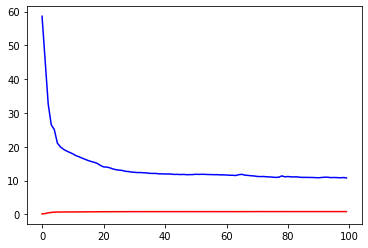

In [65]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)

In [ ]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)







dens_out_3 = Dense( 128, activation='relu' )(dout_2)


# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


#model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=1000, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )






out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)


dens_out_3 = Dense( 128, activation='relu' )(fl_out_cnn)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1)) 

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))



inputs  = Input( ( dim_size,1 ) )







# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [ fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)



service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(dens_out_3)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perClass ,
#     "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
#     "service_output": 20
}
 


model2.compile(loss=losses, loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=1e-6  ), metrics=[f1_perRow,f1_perClass,'acc'])


In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(inputs)
lstm_2 = LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(lstm_1)

lstm_2=Flatten()(lstm_2)
lstm_2 = Dense(256, activation='relu')(lstm_2)




service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(lstm_2)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())

hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)



In [ ]:
#split model
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

#splitting data
X=x_lstm_prossed_train2
y=y_lstm_prossed_train
a,b,c,d,e,f,g,h,ii,jj,k,l,m,n,o,p=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
print(len(y_lstm_prossed_train[0]))
for i in range(0,len(y_lstm_prossed_train)):
    a.append(y_lstm_prossed_train[i][0])
    b.append(y_lstm_prossed_train[i][1])
    c.append(y_lstm_prossed_train[i][2])
    d.append(y_lstm_prossed_train[i][3])
    e.append(y_lstm_prossed_train[i][4])
    f.append(y_lstm_prossed_train[i][5])
    g.append(y_lstm_prossed_train[i][6])
    h.append(y_lstm_prossed_train[i][7])
    ii.append(y_lstm_prossed_train[i][8])
    jj.append(y_lstm_prossed_train[i][9])
    k.append(y_lstm_prossed_train[i][10])
    l.append(y_lstm_prossed_train[i][11])
    m.append(y_lstm_prossed_train[i][12])
    n.append(y_lstm_prossed_train[i][13])
    o.append(y_lstm_prossed_train[i][14])
    p.append(y_lstm_prossed_train[i][15])
    
zzzz=[]    
zzzz.append(np.array(a))
zzzz.append(np.array(b))
zzzz.append(np.array(c))
zzzz.append(np.array(d))
zzzz.append(np.array(e))
zzzz.append(np.array(f))
zzzz.append(np.array(g))
zzzz.append(np.array(h))
zzzz.append(np.array(ii))
zzzz.append(np.array(jj))
zzzz.append(np.array(k))
zzzz.append(np.array(l))
zzzz.append(np.array(m))
zzzz.append(np.array(n))
zzzz.append(np.array(o))
zzzz.append(np.array(p))


for i in range(0,16):
    
    
        
        
    


    inputs  = Input( ( dim_size,1 ) )


    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
    # lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_1 =  Dense(128, activation='relu')(bi_d_1)
    lstm_2 = Dense(128, activation='relu')(lstm_1)



    # td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
    # dout_1  = Dropout(0.1)(td_1)
    dout_1  = Dropout(0.1)(lstm_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_2  = Dropout(0.2)(dense_1)





    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
    # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
    lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

    dout_1  = Dropout(0.1)(lstm_raw_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_3  = Dropout(0.2)(dense_1)





    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)



    # fl_out_1 = Flatten()(dout_2)

    fl_out_cnn = Flatten()(out)

    # out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
    out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

    dens_out_1 = Dense( 128, activation='relu' )(out_new)
    dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
    dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

    # fl2  = Flatten()(out_new)

    out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

    toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
    toService_1 = Dense( 130, name="to_service2" )(toService_1)

    service_output = Dense(1, activation="sigmoid", name = 'service_output')(toService_1)


    losses = {
    #     "service_output": f1_loss_perClass ,
        "service_output": f1_loss_perRow ,
        "service_output": "binary_crossentropy",
    }
    lossWeights = {#"service_output": 20,
                   "service_output": 30.0 ,
        "service_output": 20}




    model2 = Model(inputs=[inputs], outputs=[service_output])
    model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
    # model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    hist2 = model2.fit(x_lstm_prossed_train2, zzzz[i], epochs=200, batch_size=12500, shuffle=True, callbacks=callbacks_list)
    model2.save('number'+str(i)+'.h5')


In [ ]:
# model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=5e-5  ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=16500, shuffle=True)


In [ ]:
model2.compile(loss=f1_loss, optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=[f1,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7500, shuffle=True)

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=3500, shuffle=True)

In [ ]:
model2.save( "LSTM-sigmoid-withRemovedClasses" )

In [ ]:
plt.plot(hist2.history['loss'], c='red')
plt.plot(hist2.history['acc'], c='blue')

In [ ]:
plt.plot(hist2.history['loss'], c='red')
# plt.plot(hist2.history['acc'], c='blue')

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png')

In [ ]:
# from keras.models import load_model
# model2=load_model( "LSTM_withSigmoid_LargeData_F1_E100_B500_MSE_False"  
#            )

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.5,data=lstm_tests[i][0],gt=lstm_tests[i][1],model=model2,path=test_names[i],x=lstm_tests[i][0])
    
#     lstm_pred= model2.predict( lstm_tests[i][0])
    


# ------------- do not go any further :) ------

In [ ]:
lstm_pred= model2.predict( lstm_tests[i][0])

In [ ]:
lstm_pred= model2.predict( lstm_tests[1][0])
lstm_pred__ = np.array(list(lstm_pred))

In [ ]:
lstm_pred__ = np.array(list(lstm_pred))
print_info( lstm_tests[1][1], lstm_pred__, classes , confidance=0.43)

In [ ]:
# for i in [1] :
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)
    

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.992)
    



In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

In [ ]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

In [ ]:
model2.save( "LSTM_withSigmoid_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
pred[:10]

In [ ]:
print_info(y_lstm_prossed_test, pred, classes)

In [ ]:
pred[0]

In [ ]:
len( y_lstm_prossed_train[0] )

In [ ]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)

In [ ]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

In [ ]:
[ x for x  in  pred if np.sum(x) > 1]

In [ ]:
len(y_lstm_prossed_test)

In [ ]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [ ]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

In [ ]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [ ]:
len(x_lstm_prossed_test) + len(x_lstm_prossed_train)